# Prerequisites

```
conda installl -y numpy pandas scikit-learn matplotlib seaborn plotly ipykernel
pip install pandas_profiling
pip install git+https://github.com/WillKoehrsen/feature-selector
```

# Setup

In [40]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# activate output for values of multiple statements at once:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

# Load the data

In [41]:
df = pd.read_csv(os.getcwd()+"/data/day.csv")
df["dteday"] = pd.to_datetime(df["dteday"])
df = df.sort_values(by="dteday",ascending=True)
print("shape: ",df.shape)
df.head()

shape:  (731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Explorative data analysis

## Profile Report

*Reminder: show correlation matrix*

In [42]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

Number of variables,16
Number of observations,731
Total Missing (%),0.0%
Total size in memory,97.1 KiB
Average record size in memory,136.0 B
Numeric,10
Categorical,0
Boolean,3
Date,1
Text (Unique),0
Rejected,2


## Time series plot

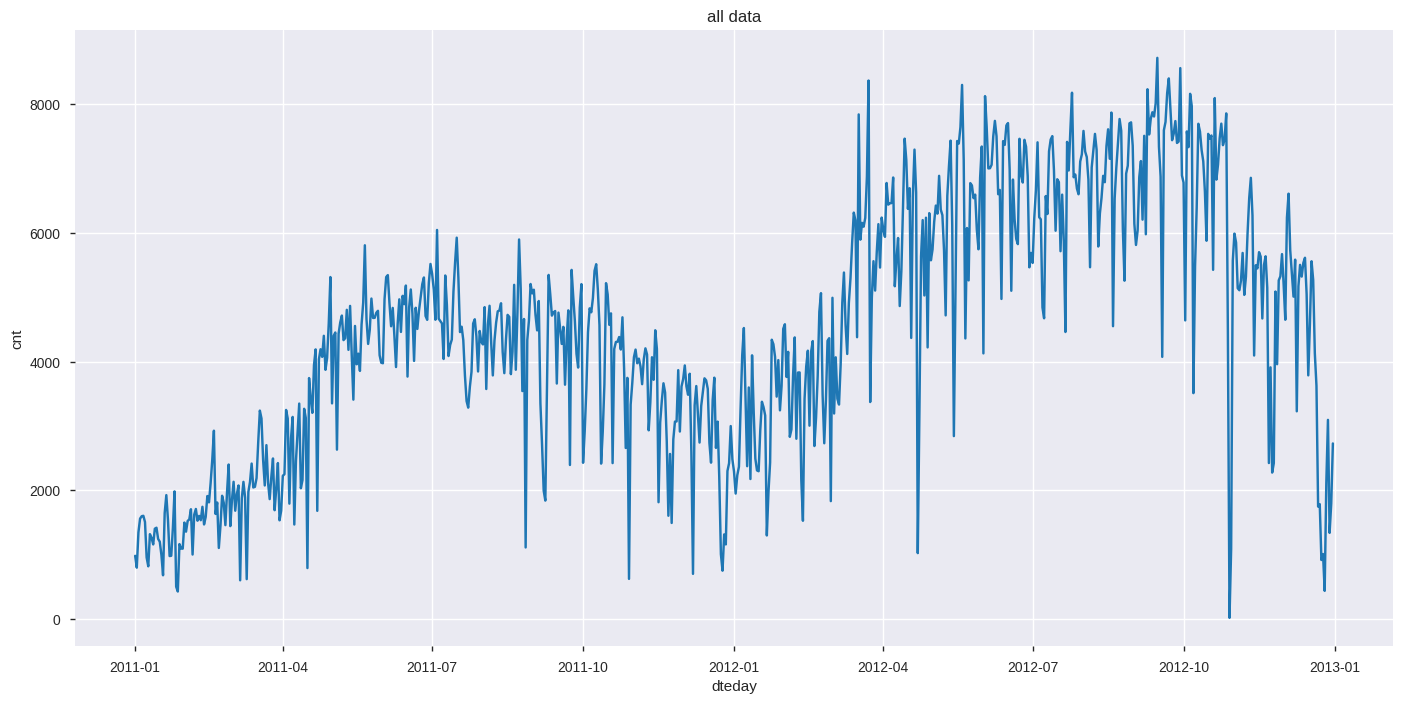

In [43]:
f, ax = plt.subplots(figsize=(17,8)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", data=df) # Plot the response over time
plt.title("all data")
plt.show(g)

# Stationary

* 1st step in time series modeling: remove the effects of the trend or season
* Statistical modeling methods assume or require the time series to be stationary to be effective
* A stationary series is one where the mean of the series is no longer a function of time


## Stationary Time Series and Forecasting

Should you make your time series stationary?

Generally, yes.

If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals.

Statistical time series methods and even modern machine learning methods will benefit from the clearer signal in the data.

But…

We turn to machine learning methods when the classical methods fail. When we want more or better results. We cannot know how to best model unknown nonlinear relationships in time series data and some methods may result in better performance when working with non-stationary observations or some mixture of stationary and non-stationary views of the problem.

The suggestion here is to treat properties of a time series being stationary or not as another source of information that can be used in feature engineering and feature selection on your time series problem when using machine learning methods.

## How do we achieve stationarity?

There are two methods that can be applied to achieve stationarity, difference the data or linear regression.

https://www.kdnuggets.com/2018/03/time-series-dummies-3-step-process.html  
https://machinelearningmastery.com/time-series-data-stationary-python/

# Is our data stationary or non-stationary?

In [44]:
# to check, run the augmented Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df["cnt"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.877448
p-value: 0.342743
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


<p style="color:red;"><b>=> we fail to reject H0</b></p>
<p style="color:red;"><b>=> our data is non-stationary and should (most likely) be transformed!</b></p>

# Feature engineering

In [45]:
# add weekend column
df["weekend"] = 0
df.loc[df["weekday"].isin([5,6]), "weekend"] = 1

# Feature Importance

* According to a gradient boosting machine (GBM) learning model
* tree-based boosting ensemble
* LightGBM library

Source: https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0

In [46]:
y = df["cnt"]
# exclude columns dteday, atemp, casual, registered, cnt:
X = df.loc[:,['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'weekend']]

from feature_selector import FeatureSelector

# Features are in train and labels are in train_labels
fs = FeatureSelector(data = X, labels = y)

# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'mse', 
                            n_iterations = 10, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[248]	valid_0's l2: 376498	valid_0's l2: 376498
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[105]	valid_0's l2: 222023	valid_0's l2: 222023
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[155]	valid_0's l2: 423058	valid_0's l2: 423058
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[165]	valid_0's l2: 302281	valid_0's l2: 302281
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[948]	valid_0's l2: 480703	valid_0's l2: 480703
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[100]	valid_0's l2: 648560	valid_0's l2: 648560
Training until validation scores don't improve for 100 rounds.
Early stopping

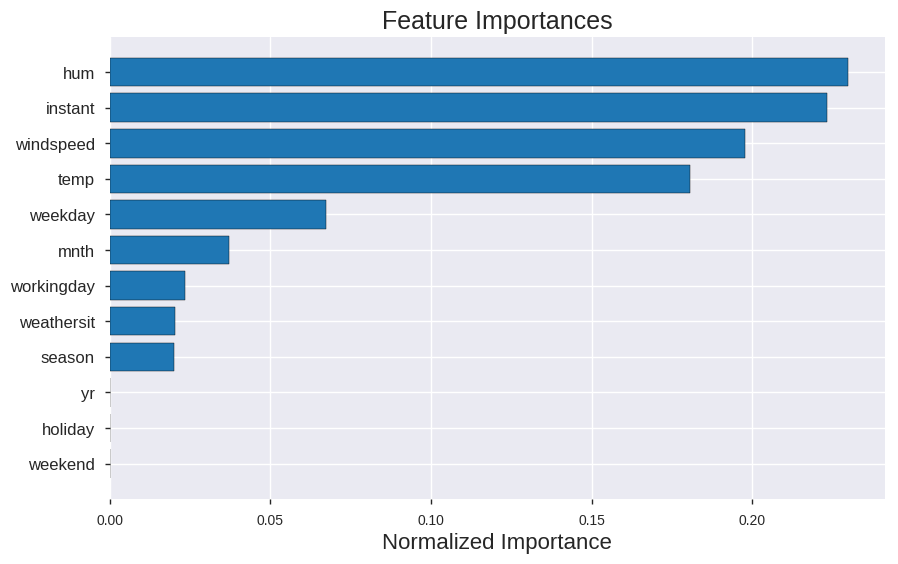

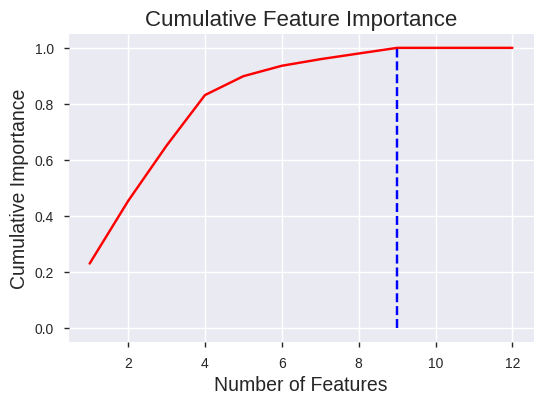

9 features required for 0.99 of cumulative importance


In [47]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

# Feature Selection and Dummy Encoding

In [48]:
# choose only importat predictors (see feature importance plot)
X = df.loc[:,['instant', 'season', 'weekday', 'workingday', 'temp', 'hum', 'windspeed']]

# add dummy-encoding
X = pd.concat([X,pd.get_dummies(df.weathersit, prefix="weathersit")],axis=1) # one-hot-encoded weathersit
X = pd.concat([X,pd.get_dummies(df.mnth, prefix="mnth")],axis=1) # one-hot endoced month

X.dtypes

instant           int64
season            int64
weekday           int64
workingday        int64
temp            float64
hum             float64
windspeed       float64
weathersit_1      uint8
weathersit_2      uint8
weathersit_3      uint8
mnth_1            uint8
mnth_2            uint8
mnth_3            uint8
mnth_4            uint8
mnth_5            uint8
mnth_6            uint8
mnth_7            uint8
mnth_8            uint8
mnth_9            uint8
mnth_10           uint8
mnth_11           uint8
mnth_12           uint8
dtype: object

# Train-Test-Split

In [49]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
# don't split randomly 
# but take the first 18 month as train data 
# and the last 6 month as test data
test_idx = df[(df["yr"]==1) & (df["mnth"]>5)].index

X_test=X.iloc[test_idx,]
y_test=y.iloc[test_idx,]

X_train=X.drop(test_idx)
y_train=y.drop(test_idx)

# Standardize the data

In [51]:
# it is best to apply ridge regression after standardizing the predictors!

COLUMNS_TO_STANDARDIZE = ['temp', 'hum', 'windspeed']

X_train_temp = X_train.loc[:,COLUMNS_TO_STANDARDIZE]
X_test_temp = X_test.loc[:,COLUMNS_TO_STANDARDIZE]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_temp)
X_train_temp = scaler.transform(X_train_temp)
X_test_temp = scaler.transform(X_test_temp)

# write back to DataFrame from the temp numpy arrays
i=0
for col in COLUMNS_TO_STANDARDIZE:
    X_train.loc[:,col] = X_train_temp[:,i]
    X_test.loc[:,col] = X_test_temp[:,i]
    i += 1

"Very often, the independent variables are centered and scaled in order to have variance 1."  
(Source: https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression) 


# Ridge regression

In [52]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
reg.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [53]:
print("intercept: ", reg.intercept_)
pd.DataFrame({"col" : X_train.columns, "coef" : reg.coef_})

intercept:  685.8200466447565


,col,coef
0,instant,5.330982
1,season,392.285501
2,weekday,52.546828
3,workingday,77.989521
4,temp,829.013847
5,hum,-222.734184
6,windspeed,-229.154451
7,weathersit_1,682.386354
8,weathersit_2,306.437599
9,weathersit_3,-988.823953


In [54]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

print("R² (train) = {:.4}".format(r2_score(y_train, reg.predict(X_train))))

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE = {0:,.0f}".format(mse))
print("RMSE = {0:,.0f}".format(np.sqrt(mse)))

R² (train) = 0.8422
MSE = 1,176,485
RMSE = 1,085


# Hyperparameter Optimization

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

n_alphas = 200
alphas = np.logspace(-3, 5, n_alphas)
parameters = {
    'reg__alpha': (alphas).tolist()
}

pipe = Pipeline([
    ('reg', linear_model.Ridge())
])

# perform gridsearch to get the best regularizer
gs = GridSearchCV(estimator=pipe, param_grid=parameters, 
                  scoring="neg_mean_squared_error", cv=5, n_jobs=-1, iid=False)
gs.fit(X_train, y_train)
best_alpha = gs.best_params_["reg__alpha"]
best_alpha

{'reg__alpha': 2.612675225563329}

In [58]:
reg = gs.best_estimator_.named_steps['reg']

print("intercept: ", reg.intercept_)
pd.DataFrame({"col" : X_train.columns, "coef" : reg.coef_})

intercept:  993.2893250052784


,col,coef
0,instant,5.339244
1,season,289.964679
2,weekday,51.085326
3,workingday,79.559090
4,temp,811.453153
5,hum,-234.018991
6,windspeed,-231.220841
7,weathersit_1,627.838271
8,weathersit_2,275.337853
9,weathersit_3,-903.176125


In [59]:
print("R² (train) = {:.4}".format(r2_score(y_train, reg.predict(X_train))))

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE = {0:,.0f}".format(mse))
print("RMSE = {0:,.0f}".format(np.sqrt(mse)))

R² (train) = 0.8403
MSE = 1,214,746
RMSE = 1,102


# Plot test vs. pred

Text(0.5, 1.0, 'test vs. pred')

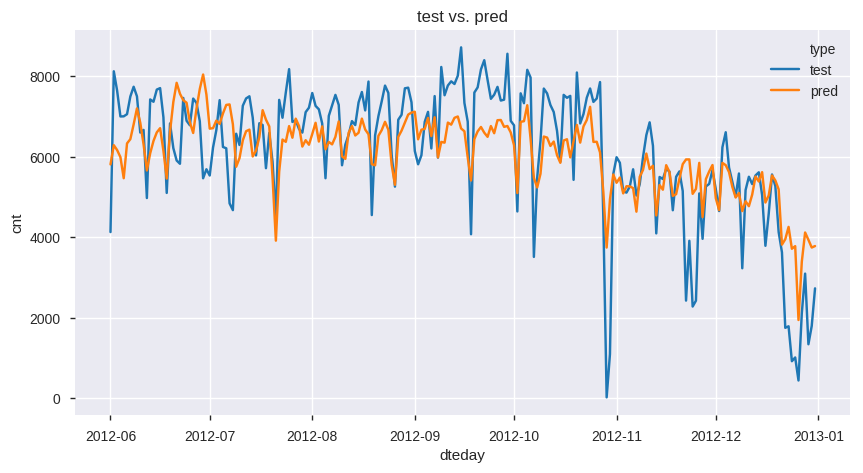

In [18]:
# prepare data for plotting (convert into long format)
test = pd.DataFrame({"dteday":df.iloc[test_idx,]["dteday"],
                         "cnt":y_test,
                         "type":"test"})
pred = pd.DataFrame({"dteday":df.iloc[test_idx,]["dteday"],
                         "cnt":y_pred,
                         "type":"pred"})
long_data=test.append(pred, ignore_index=True)

f, ax = plt.subplots(figsize=(10,5)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", hue="type", data=long_data) # Plot the response over time
plt.title("test vs. pred")

In [19]:
from plotly.offline import init_notebook_mode, iplot
import plotly.tools as tls
init_notebook_mode(connected=True)
plotly_fig = tls.mpl_to_plotly( f ) # ...produced some warnings...
iplot(plotly_fig)

In [20]:
import plotly.graph_objs as go
layout = go.Layout(
    autosize=False,
    width=600,
    height=600
)

# optinal TODO: construct the whole diagram via plotly API (instead of converting from matplotlib/seaborn)

# Plot Ridge coefficients as a function of the regularization

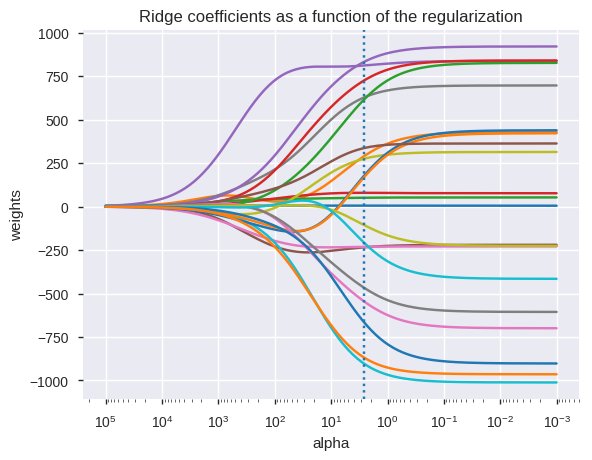

In [67]:
# #############################################################################
# Compute paths

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

plt.axvline(x=best_alpha, linestyle=":") # add vertical line for best alpha

plt.show()

Source: http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py

# Lessons Learned

* time data is different, avoid random sampling when splitting the data into train and test
    * samples are not independent
* make data stationary
* for linear models
    * model time effects as dummies (do not standardize these b/c of interpretability)
    * convert date into integer (begin at 0, otherwise the intercept is effected)

# Further Read
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/  
https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b  
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html